# Исследование вычисления метрики

In [1]:
import os
import json
from tqdm.auto import tqdm
import torch
import numpy as np
from torch_geometric.loader import DataLoader
from hack_lap.utils.dataset import get_gcn_dataset
from hack_lap.utils.evaluate import evaluate, precision_recall
from hack_lap.models.gcn import GCNModel

In [2]:
import matplotlib
# matplotlib.use('Qt5Agg')
# %matplotlib qt5
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
DIR_MODEL = os.path.join('..', 'data', 'model')
exp_name = 'mdl-L4-H32-Pmean-NF-BF-v2-20000'
device = 'cpu'
batch_size = 16

with open(os.path.join(DIR_MODEL, exp_name + '.json')) as fp:
    cfg = json.load(fp)

cfg_model = {
    'num_hidden_layers': cfg['num_hidden_layers'],
    'hidden_size': cfg['hidden_size'],
    'intermediate_size': cfg['intermediate_size'],
    'pooling': cfg['pooling'],
    'normalize': cfg['normalize'],
    'bias': cfg['bias'],
}
model = GCNModel(**cfg_model)
model.load_state_dict(
    torch.load(
        os.path.join(DIR_MODEL, exp_name + '.pt'),
        map_location='cpu'
    )
)
model.train()
model.to(device);

In [4]:
_, dataset_dev = get_gcn_dataset(
    filename='../data/train.pkl',
    dev_frac=cfg['dev_frac'],
    positive_multiplier=cfg['positive_multiplier'],
    seed=cfg['seed']
)
loader = DataLoader(dataset_dev, batch_size=batch_size)


In [5]:
bce_loss, yt, yp = evaluate(model, loader, device, repeat=64)

In [6]:
s = np.std(yp, axis=1)
ym = np.mean(yp, axis=1)

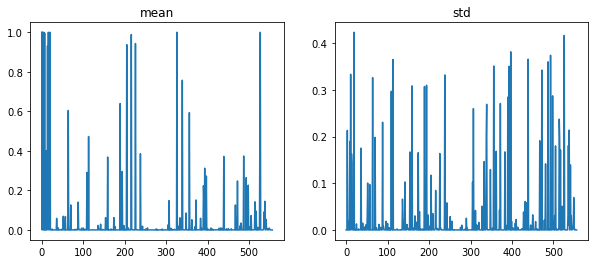

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(ym);
ax2.plot(s);
ax1.set_title('mean');
ax2.set_title('std');

In [8]:
rp0, rp1, th = precision_recall(yt, ym, cls_count_0=5000, cls_count_1=250)
f1_0 = 2.0 * rp0[0] * rp0[1] / (rp0[0] + rp0[1] + 1e-5)
f1_1 = 2.0 * rp1[0] * rp1[1] / (rp1[0] + rp1[1] + 1e-5)

threshold: 0.4000000059604645


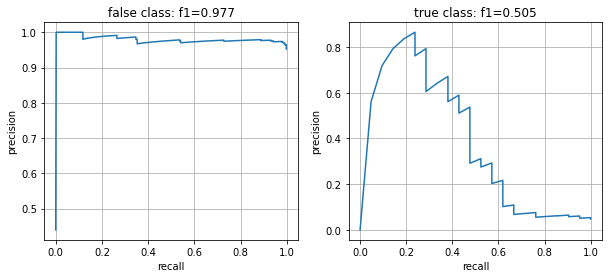

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(rp0[0], rp0[1]);
ax2.plot(rp1[0], rp1[1]);
ax1.set_ylabel('precision')
ax1.set_xlabel('recall')
ax2.set_ylabel('precision')
ax2.set_xlabel('recall')

ii = np.argmax(f1_1)
t = round(th[ii], 3)

print(f'threshold: {t}')
ax1.set_title(f'false class: f1={round(f1_0[ii], 3)}')
ax2.set_title(f'true class: f1={round(f1_1[ii], 3)}')

ax1.grid(True);
ax2.grid(True);

In [13]:
ymt = ym.tolist()
ytt = yt.tolist()

new_yp = []
new_yt = []
stat_th = []
for i in range(len(ymt)):
    rp0, rp1, th = precision_recall(
        np.array(ytt[:i] + ytt[i+1:]), 
        np.array(ymt[:i] + ymt[i+1:]), 
        cls_count_0=5000, 
        cls_count_1=200
    )
    f1 = 2.0 * rp1[0] * rp1[1] / (rp1[0] + rp1[1] + 1e-5)
    ii = np.argmax(f1)
    stat_th.append(th[ii])
    new_yt.append(ytt[i])
    new_yp.append(int(ymt[i] > th[ii]))
    # new_yp.append(int(ymt[i] > 0.5))
new_yt = np.array(new_yt)
new_yp = np.array(new_yp)
np.mean(stat_th)

0.4007833350175587

In [11]:
tp = (new_yp * new_yt).sum()
tn = ((1 - new_yp) * (1 - new_yt)).sum()
fp = (new_yp * (1 - new_yt)).sum()
fn = ((1 - new_yp) * new_yt).sum()

cm = np.array([[tp, fn], [fp, tn]])
cm

array([[  8.,  13.],
       [ 11., 525.]])

In [12]:
pr = tp / (tp + fp)
re = tp / (tp + fn)
f1 = 2 * re * pr / (pr + re)
re, pr, f1

(0.38095238095238093, 0.42105263157894735, 0.4)